## Optogenetic Two Component System Control Model
This file demonstrates the open loop simulation of the optogenetic two component system using minimal model

In [1]:
# three_eqn_notebook.py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lmfit

# run_constant_3eqn is the simulator that runs the open loop experiment using the minimal model
from model_equations_and_simulators.run_constant_3eqn import run_constant

In [2]:
# Load datasets
data1 = pd.read_csv('experiment_data/P-FL_OD_run_data_042325.csv')
data2 = pd.read_csv('experiment_data/P-FL_OD_run_data_040625.csv')

# Setpoints 
st_pt_1 = 11500
st_pt_2 = 18500

# Only extract P-control wells
# P_control_wells = ['B9', 'C9', 'D9', 'E9', 'F9', 'G9']

P1_data1 = data1[['SP1_1',  'SP1_2',  'SP1_3', 'SP1_4', 'SP1_5', 'SP1_6']].to_numpy()
P2_data1 = data1[['SP2_1',  'SP2_2',  'SP2_3', 'SP2_4', 'SP2_5', 'SP2_6']].to_numpy()

P1_data2 = data2[['SP1_1',  'SP1_2',  'SP1_3']].to_numpy()
P2_data2 = data2[['SP2_1',  'SP2_2',  'SP2_3']].to_numpy()

# Extract Green/Red constants (with replicates for 040825)
red_data1 = data1[['R1']].to_numpy()
green_data1 = data1[['G1']].to_numpy()

# For 0401025, Green and Red have only 1 well each
green_data2 = data2[['G1',  'G2', 'G3']].to_numpy()
red_data2 = data2[['R1',  'R2',  'R3']].to_numpy()

# Automatically find the smaller length
min_length = min(P1_data1.shape[0], P1_data2.shape[0])

green_data1 = green_data1[:min_length, :]
green_data2 = green_data2[:min_length, :]
red_data1 = red_data1[:min_length, :]
red_data2 = red_data2[:min_length, :]

# Merge and compute statistics for green and red experimental data
green_merged = np.hstack((green_data1, green_data2))
red_merged = np.hstack((red_data1, red_data2))

green_mean = np.mean(green_merged, axis=1)
green_std = np.std(green_merged, axis=1)

red_mean = np.mean(red_merged, axis=1)
red_std = np.std(red_merged, axis=1)

# Normalize using max of green mean for consistent scale
green_max = np.max(green_mean)
green_mean_norm = green_mean / green_max
green_std_norm = green_std / green_max

red_mean_norm = red_mean / green_max
red_std_norm = red_std / green_max

# Time vector
interval = 10
time = np.arange(interval, (min_length + 1) * interval, interval)

In [3]:
# Parameter setup
p = pd.read_csv('parameters/3_eqn_model_params_file.csv').to_numpy()
p = p[:,2]

params = lmfit.Parameters()

params.add('k_tx', value=p[0], min=0.1, max=20)
params.add('d_m', value=p[1], min=0.05, max=0.5)
params.add('k_tl', value=p[2], min=0.1, max=5)
params.add('Kc', value=p[3], min=0.001, max=1000)
params.add('l0', value=p[4], min=0.001, max=0.5)
params.add('n_gamma', value=p[5], min=0.2, max=0.9)
params.add('d_p', value=p[6], min=1e-6, max=0.1)
params.add('k_gr', value=p[7], min=0.001, max=1.0, vary = False)
params.add('Ac_green', value=p[8], min=1, max=100)
params.add('Ac_dark', value=p[9], min=1, max=100)
params.add('Ac_red', value=p[10], min=1e-3, max=100)
params.add('C_max', value=p[11], vary=False)
params.add('C_0', value=p[12], vary=False)
params.add('M_0', value=p[13], min = 0, max = 1e3)
params.add('P_0', value=p[14], min = 0, max = 1e3)

# Initial conditions: [M, P, C]
x0 = [params['M_0'].value, params['P_0'].value, params['C_0'].value]

In [4]:
# Final time
t_final = 960

# Run open loop simulations
Tg, Pg, Sg = run_constant(t_final, x0, params, constant_input='green')
Tr, Pr, Sr = run_constant(t_final, x0, params, constant_input='red')
Td, Pd, Sd = run_constant(t_final, x0, params, constant_input='dark')

(0.0, 561.5089304736463)

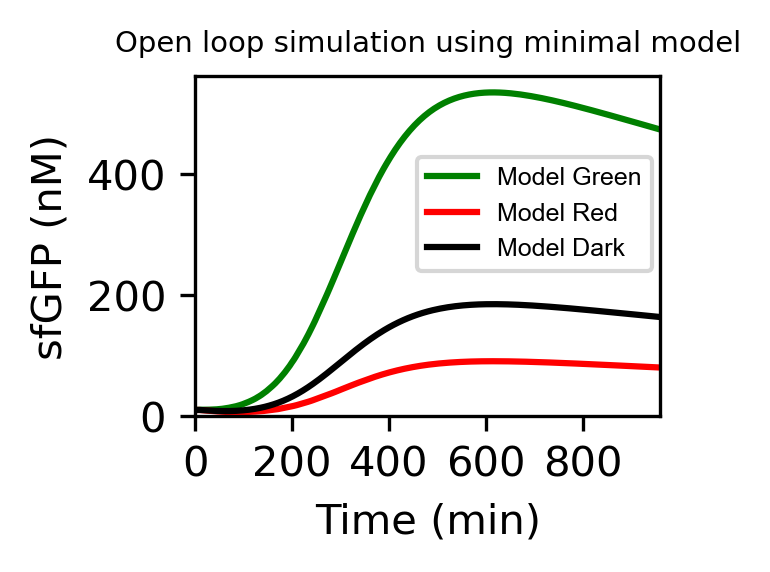

In [5]:
# Model simulation
fig, ax2 = plt.subplots(figsize=(2, 1.5), dpi = 300)

# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 6
})
tick_fontsize = 7

# Line width and alpha
lwd_model = 1
ax2.plot(Tg, Pg, 'green', label='Model Green')
ax2.plot(Tr, Pr, 'red', label='Model Red')
ax2.plot(Td, Pd, 'k', label='Model Dark')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('sfGFP (nM)')
ax2.set_title('Open loop simulation using minimal model')
ax2.legend(loc='best', bbox_to_anchor=(0.45, 0.8))
ax2.set_xlim((0, 960))
ax2.set_ylim((0))

In [6]:
# Visualize and export parameters
# Uncomment the commented part to export the parmeter file as a csv with desired name

param_dict = params.valuesdict()
# param_dict_guess_df = dict()
# param_dict_guess_df['Param name'] = param_dict.keys()
# param_dict_guess_df['Param'] = param_dict.values()
# param_data = pd.DataFrame(data = param_dict_guess_df)
# param_data.to_csv('TCS_3eqn_model_guess_052725.csv')
param_dict

{'k_tx': 3.0,
 'd_m': 0.15,
 'k_tl': 1.1,
 'Kc': 10.0,
 'l0': 0.005,
 'n_gamma': 0.9,
 'd_p': 0.001,
 'k_gr': 0.012,
 'Ac_green': 80.0,
 'Ac_dark': 3.5,
 'Ac_red': 1.0,
 'C_max': 836676923.0,
 'C_0': 46870588.0,
 'M_0': 3.0,
 'P_0': 10.0}